In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [6]:
gwic_filename = 'data/missoula_valley_monitored_wells_data.csv'
usgs_filename = 'data/clark_fk_above_missoula_q.csv'
gw_df = pd.read_csv(gwic_filename, index_col='time', parse_dates=True)
q_df = pd.read_csv(usgs_filename, index_col='time', parse_dates=True)

In [7]:
df = pd.concat([q_df, gw_df], axis=1, join='inner')

## Data Imputation

### Linear interpolation

In [8]:
# Run 100 times to get average error
for i in range(100):
    
    # Make sure dataset is clean each time
    lin_imputed = df.copy()
    
    # Loop through columns
    for c in np.arange(1, df.shape[1]):

        # Drop preceding NaNs
        first_ind = lin_imputed.iloc[:, c].first_valid_index()
        new_df = lin_imputed.iloc[:, c][first_ind:]

        # Pull out 5 random points for test data
        values_indices = new_df.dropna().index
        test_indices = np.random.choice(values_indices[1:], 5, replace=False)
        test_values = new_df[test_indices]
        new_df.loc[test_indices] = np.nan

        # Linear interpolation
        new_df_int = new_df.interpolate(method='linear')
        new_df_int_ind = new_df_int.index

        # Update dataframe
        lin_imputed.iloc[:, c][new_df_int_ind] = new_df_int

        # Aggregate test data
        test_data = pd.concat([test_values, new_df_int[test_indices]], axis=1)
        test_data.columns = ['value', 'estimate']
        if i == 0 and c == 1:
            lin_test_data = test_data
        else:
            lin_test_data = pd.concat([lin_test_data, test_data], axis=0)

In [9]:
# Calculate error statistics
lin_mae = mean_absolute_error(lin_test_data['value'], lin_test_data['estimate'])
lin_mse = mean_squared_error(lin_test_data['value'], lin_test_data['estimate'])
lin_rmse = np.sqrt(lin_mse)
lin_mape = np.mean(np.abs((lin_test_data['value'] - lin_test_data['estimate']) / lin_test_data['value'])) * 100
lin_rsquared = r2_score(lin_test_data['value'], lin_test_data['estimate'])

lin_error_stats = pd.DataFrame({
    'MAE': lin_mae,
    'MSE': lin_mse,
    'RMSE': lin_rmse,
    'MAPE': lin_mape,
    'R^2': lin_rsquared
}, index=['Linear Interpolation'])

lin_error_stats

,MAE,MSE,RMSE,MAPE,R^2
Linear Interpolation,2.147525,12.20134,3.493042,13.39949,0.973667


<Axes: xlabel='value', ylabel='estimate'>

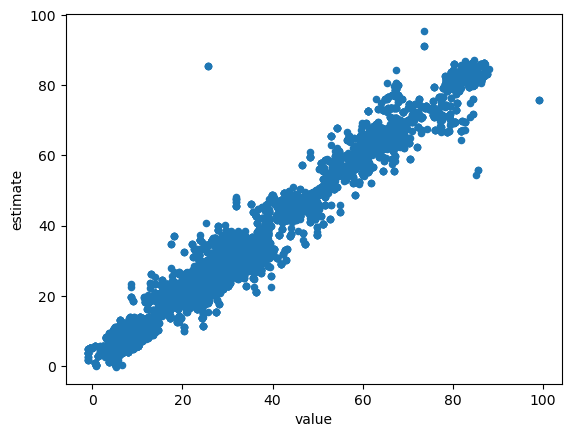

In [10]:
lin_test_data.plot.scatter(x='value', y='estimate')

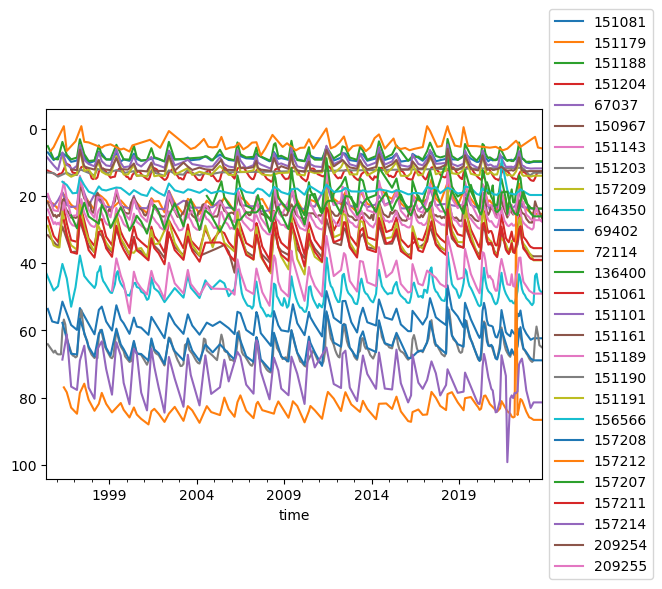

In [11]:
ax = lin_imputed.iloc[:, 1:].plot(legend=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.invert_yaxis()

### Seasonal Trend Decomposition using Loess (STL)
Inspired by [Medium blog post](https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7)

In [12]:
# Run 100 times to get average error
for i in range(100):
    
    # Make sure dataset is clean each time
    stl_imputed = df.copy()
    
    # Loop through columns
    for c in np.arange(1, df.shape[1]):
        
        # Drop preceding NaNs
        first_ind = stl_imputed.iloc[:, c].first_valid_index()
        new_df = stl_imputed.iloc[:, c][first_ind:]
        
        # Pull out 5 random points for test data
        values_indices = new_df.dropna().index
        test_indices = np.random.choice(values_indices[1:], 5, replace=False)
        test_values = new_df[test_indices]
        new_df.loc[test_indices] = np.nan

        # Get indices of NaNs
        imputed_indices = new_df.isna().index

        # Need to interpolate because STL doesn't handle NaNs
        new_df = new_df.ffill()

        # Apply STL decomposition to the groundwater level data
        stl = STL(new_df, seasonal=7, period=12, robust=True)
        res = stl.fit()

        # Extract the seasonal component
        seasonal = res.seasonal
        
        # Created deseasonalized groundwater level data
        df_deseas = new_df - seasonal

        # Interpolate the deseasonalized data
        df_deseas_int = df_deseas.interpolate(method='linear')

        # Add seasonal component back to deseasonalized data
        df_imputed = df_deseas_int + seasonal
        
        # Replace NaNs with imputed data
        stl_imputed.iloc[:, c][imputed_indices] = df_imputed[imputed_indices]
        
        # Aggregate test data
        test_data = pd.concat([test_values, df_imputed[test_indices]], axis=1)
        test_data.columns = ['value', 'estimate']
        if i == 0 and c == 1:
            stl_test_data = test_data
        else:
            stl_test_data = pd.concat([stl_test_data, test_data], axis=0)

In [13]:
# Calculate error statistics
stl_mae = mean_absolute_error(stl_test_data['value'], stl_test_data['estimate'])
stl_mse = mean_squared_error(stl_test_data['value'], stl_test_data['estimate'])
stl_rmse = np.sqrt(stl_mse)
stl_mape = np.mean(np.abs((stl_test_data['value'] - stl_test_data['estimate']) / stl_test_data['value'])) * 100
stl_rsquared = r2_score(stl_test_data['value'], stl_test_data['estimate'])
stl_mape

stl_error_stats = pd.DataFrame({
    'MAE': stl_mae,
    'MSE': stl_mse,
    'RMSE': stl_rmse,
    'MAPE': stl_mape,
    'R^2': stl_rsquared
}, index=['STL Decomposition'])

stl_error_stats


,MAE,MSE,RMSE,MAPE,R^2
STL Decomposition,2.673694,17.828701,4.222405,15.605513,0.961569


<Axes: xlabel='time'>

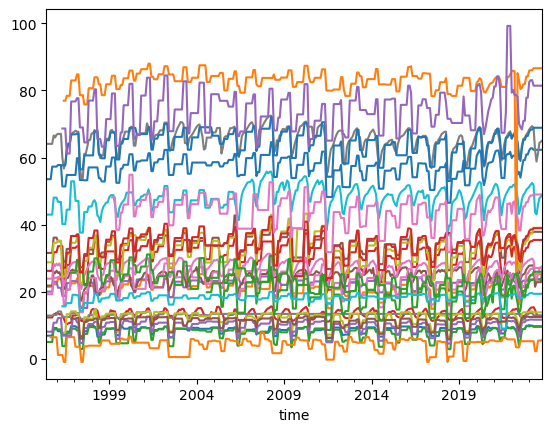

In [14]:
# Plot
stl_imputed.iloc[:, 1:].plot(legend=False)

## Regression imputation using Q and DOY 
Inspired by [Medium blog post](https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7)

In [15]:
# Run 100 times to get average error
for i in range(100):
    
    # Make sure dataset is clean each time
    reg_imputed = df.copy()
    
    # Loop through columns
    for c in np.arange(1, df.shape[1]):

        # Drop preceding NaNs
        first_ind = df.iloc[:, c].first_valid_index()
        new_df = df.iloc[:, [0, c]][first_ind:]  
            
        # Pull out 5 random points for test data
        values_indices = new_df.iloc[:, [0, 1]].dropna().index
        test_indices = np.random.choice(values_indices, 5, replace=False)
        test_values = new_df.iloc[:, 1][test_indices]
        new_df.iloc[:, 1].loc[test_indices] = np.nan

        # Get indices of NaNs
        imputed_indices = new_df.iloc[:, 1][new_df.iloc[:, 1].isnull()].index

        # Drop rows with missing values
        df_dropped = new_df.iloc[:, [0, 1]].dropna()    

        # Get predictors (Q and doy) and dependent variable
        X = np.column_stack((df_dropped.Q.values, df_dropped.index.dayofyear.values))
        Y = df_dropped.iloc[:, 1].values

        # Instantiate model
        model = LinearRegression()

        # Fit model
        model.fit(X, Y)

        # Predict missing values
        pred1 = new_df.loc[imputed_indices, 'Q'].values
        pred2 = new_df.loc[imputed_indices, 'Q'].index.dayofyear.values
        preds = np.column_stack((pred1, pred2))
        predicted = model.predict(preds)
        
        # Fill missing values with predicted values
        reg_imputed.iloc[:, c][imputed_indices] = predicted

        # Aggregate test data
        test_data = pd.concat([test_values, reg_imputed.iloc[:, c][test_indices]], axis=1)
        test_data.columns = ['value', 'estimate']
        if i == 0 and c == 1:
            reg_test_data = test_data
        else:
            reg_test_data = pd.concat([reg_test_data, test_data], axis=0)

In [16]:
# Calculate error statistics
reg_mae = mean_absolute_error(reg_test_data['value'], reg_test_data['estimate'])
reg_mse = mean_squared_error(reg_test_data['value'], reg_test_data['estimate'])
reg_rmse = np.sqrt(reg_mse)
reg_mape = np.mean(np.abs((reg_test_data['value'] - reg_test_data['estimate']) / reg_test_data['value'])) * 100
reg_rsquared = r2_score(reg_test_data['value'], reg_test_data['estimate'])
reg_mape

reg_error_stats = pd.DataFrame({
    'MAE': reg_mae,
    'MSE': reg_mse,
    'RMSE': reg_rmse,
    'MAPE': reg_mape,
    'R^2': reg_rsquared
}, index=['Q and DOY Regression'])

reg_error_stats

,MAE,MSE,RMSE,MAPE,R^2
Q and DOY Regression,1.553181,5.540618,2.353852,7.688987,0.988102


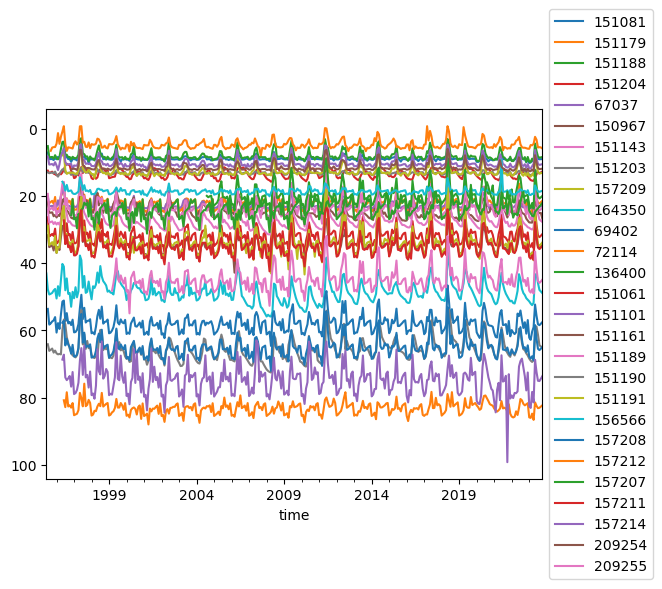

In [17]:
ax = reg_imputed.iloc[:, 1:].plot(legend=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.invert_yaxis()

In [18]:
pd.concat([lin_error_stats, stl_error_stats, reg_error_stats], axis=0)

,MAE,MSE,RMSE,MAPE,R^2
Linear Interpolation,2.147525,12.201340,3.493042,13.399490,0.973667
STL Decomposition,2.673694,17.828701,4.222405,15.605513,0.961569
Q and DOY Regression,1.553181,5.540618,2.353852,7.688987,0.988102


### Deep Learning
Still to come...

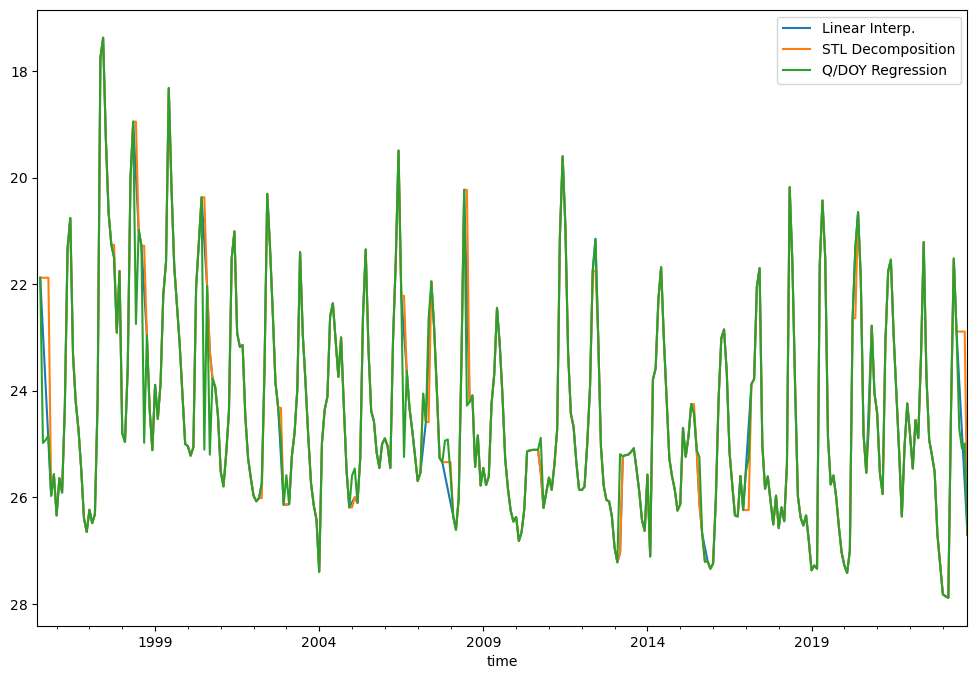

In [77]:
gwic_id = '150967'
ax = lin_imputed.loc[:, gwic_id].plot(legend=False, figsize=[12, 8])
stl_imputed.loc[:, gwic_id].plot(legend=False, ax=ax)
reg_imputed.loc[:, gwic_id].plot(legend=False, ax=ax)

# lin_imputed.Q.plot(legend=False, ax=ax, secondary_y=True)
ax.invert_yaxis()
ax.legend(['Linear Interp.', 'STL Decomposition', 'Q/DOY Regression'])

## STL and regression imputation using Clark Fk flows

In [79]:
# Copy dataframe to create new dataframe for imputed data
stlreg_imputed = df.copy()

for c in np.arange(1, df.shape[1]):
    
    # Drop preceding NaNs
    first_ind = stlreg_imputed.iloc[:, c].first_valid_index()
    new_df = stlreg_imputed.iloc[:, c][first_ind:]
    
    # Pull out 5 random points for test data
    values_indices = new_df.dropna().index
    test_indices = np.random.choice(values_indices[1:], 5, replace=False)
    test_values = new_df[test_indices]
    new_df.loc[test_indices] = np.nan

    # Get indices of NaNs
    imputed_indices = new_df.isna().index

    # Need to interpolate because STL doesn't handle NaNs
    # Use linear regression model instead of ffill
    df_dropped = stlreg_imputed.iloc[:, [0, c]].dropna()    
    X = df_dropped.Q.values.reshape(-1, 1)  # Predictors need to be 2D array
    Y = df_dropped.iloc[:, 1].values
    model = LinearRegression()
    model.fit(X, Y)
    predicted = model.predict(stlreg_imputed.loc[imputed_indices, 'Q'].values.reshape(-1, 1))
    new_df[imputed_indices] = predicted
    
    # Apply STL decomposition to the groundwater level data
    stl = STL(new_df, seasonal=7, period=12, robust=True)
    res = stl.fit()

    # Extract the seasonal component
    seasonal = res.seasonal
    
    # Created deseasonalized groundwater level data
    df_deseas = new_df - seasonal

    # Interpolate the deseasonalized data
    df_deseas_int = df_deseas.interpolate(method='linear')

    # Add seasonal component back to deseasonalized data
    df_imputed = df_deseas_int + seasonal
    
    # Replace NaNs with imputed data
    stlreg_imputed.iloc[:, c][imputed_indices] = df_imputed[imputed_indices]
    
    # Aggregate test data
    test_data = pd.concat([test_values, df_imputed[test_indices]], axis=1)
    test_data.columns = ['value', 'estimate']
    if c == 1:
        stlreg_test_data = test_data
    else:
        stlreg_test_data = pd.concat([stlreg_test_data, test_data], axis=0)

In [80]:
# Calculate error statistics
stlreg_mae = mean_absolute_error(stlreg_test_data['value'], stlreg_test_data['estimate'])
stlreg_mse = mean_squared_error(stlreg_test_data['value'], stlreg_test_data['estimate'])
stlreg_rmse = np.sqrt(stlreg_mse)
stlreg_mape = np.mean(np.abs((stlreg_test_data['value'] - stlreg_test_data['estimate']) / stlreg_test_data['value'])) * 100
stlreg_rsquared = r2_score(stlreg_test_data['value'], stlreg_test_data['estimate'])
stlreg_mape

10.626210297703606

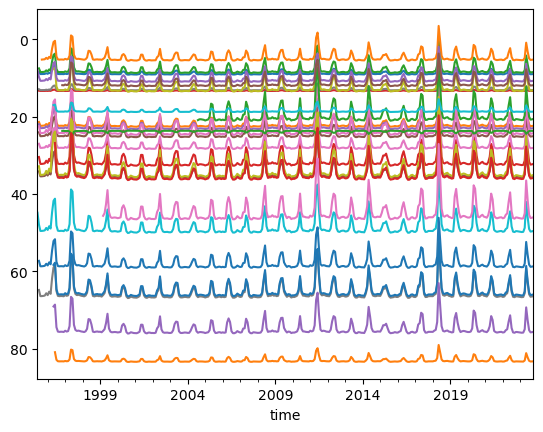

In [81]:
ax = stlreg_imputed.iloc[:, 1:].plot(legend=False)
ax.invert_yaxis()